In [1]:
# Import
import os
import math
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from tqdm import tqdm
from diffusers import AutoencoderKL
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTokenizer, CLIPTextModel
import torch.optim.lr_scheduler as lr_scheduler
from torch.amp import GradScaler, autocast

2025-04-23 15:00:42.600432: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 15:00:42.884295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745395242.991683   16147 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745395243.024304   16147 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745395243.254249   16147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed set to {seed}")


set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Seed set to 42
cpu


In [3]:
# Download dataset if not already present
# Download emoji dataset
# https://drive.google.com/file/d/15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h/view?usp=sharing
# !gdown 15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h
# !unzip blobs_crawled_data.zip

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, num_attn_heads, hidden_dim, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.num_heads = num_attn_heads
        self.head_size = hidden_dim // num_attn_heads

        self.qkv_proj = nn.Linear(
            hidden_dim, 3 * hidden_dim, bias=in_proj_bias)
        self.output_proj = nn.Linear(
            hidden_dim, hidden_dim, bias=out_proj_bias)

    def forward(self, features, use_causal_mask=False):
        b, s, d = features.shape

        qkv_combined = self.qkv_proj(features)
        q_mat, k_mat, v_mat = torch.chunk(qkv_combined, 3, dim=-1)

        q_mat = q_mat.view(b, s, self.num_heads,
                           self.head_size).permute(0, 2, 1, 3)
        k_mat = k_mat.view(b, s, self.num_heads,
                           self.head_size).permute(0, 2, 1, 3)
        v_mat = v_mat.view(b, s, self.num_heads,
                           self.head_size).permute(0, 2, 1, 3)

        qk = torch.matmul(q_mat, k_mat.transpose(-2, -1))
        sqrt_qk = qk / math.sqrt(self.head_size)

        if use_causal_mask:
            causal_mask = torch.triu(torch.ones_like(
                sqrt_qk, dtype=torch.bool), diagonal=1)
            sqrt_qk = sqrt_qk.masked_fill(causal_mask, -torch.inf)

        attn_weights = torch.softmax(sqrt_qk, dim=-1)
        attn_values = torch.matmul(attn_weights, v_mat)

        attn_values = attn_values.permute(0, 2, 1, 3).contiguous()
        attn_values = attn_values.view(b, s, d)

        final_output = self.output_proj(attn_values)
        return final_output

In [5]:
class CrossAttention(nn.Module):
    def __init__(self, num_attn_heads, query_dim, context_dim, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.num_heads = num_attn_heads
        self.head_size = query_dim // num_attn_heads

        self.query_map = nn.Linear(query_dim, query_dim, bias=in_proj_bias)
        self.key_map = nn.Linear(context_dim, query_dim, bias=in_proj_bias)
        self.value_map = nn.Linear(context_dim, query_dim, bias=in_proj_bias)

        self.output_map = nn.Linear(query_dim, query_dim, bias=out_proj_bias)

    def forward(self, query_input, context_input):
        b_q, s_q, d_q = query_input.shape
        _, s_kv, _ = context_input.shape

        q_mat = self.query_map(query_input)
        k_mat = self.key_map(context_input)
        v_mat = self.value_map(context_input)

        q_mat = q_mat.view(b_q, s_q, self.num_heads,
                           self.head_size).permute(0, 2, 1, 3)
        k_mat = k_mat.view(b_q, s_kv, self.num_heads,
                           self.head_size).permute(0, 2, 1, 3)
        v_mat = v_mat.view(b_q, s_kv, self.num_heads,
                           self.head_size).permute(0, 2, 1, 3)

        qk = torch.matmul(q_mat, k_mat.transpose(-2, -1))
        sqrt_qk = qk / math.sqrt(self.head_size)
        attn_weights = torch.softmax(sqrt_qk, dim=-1)

        attn_values = torch.matmul(attn_weights, v_mat)
        attn_values = attn_values.permute(0, 2, 1, 3).contiguous()
        attn_values = attn_values.view(b_q, s_q, d_q)

        final_output = self.output_map(attn_values)
        return final_output

In [6]:
class DDPMScheduler:
    def __init__(
        self,
        random_generator,
        train_timesteps=1000,
        diffusion_beta_start=0.00085,
        diffusion_beta_end=0.012
    ):

        self.betas = torch.linspace(
            diffusion_beta_start ** 0.5, diffusion_beta_end ** 0.5, train_timesteps,
            dtype=torch.float32) ** 2
        self.alphas = 1.0 - self.betas
        self.alphas_cumulative_product = torch.cumprod(self.alphas, dim=0)
        self.one_val = torch.tensor(1.0)
        self.prng_generator = random_generator
        self.total_train_timesteps = train_timesteps
        self.schedule_timesteps = torch.from_numpy(
            np.arange(0, train_timesteps)[::-1].copy())

    def set_steps(self, num_sampling_steps=50):
        self.num_sampling_steps = num_sampling_steps
        step_scaling_factor = self.total_train_timesteps // self.num_sampling_steps
        timesteps_for_sampling = (
            np.arange(0, num_sampling_steps) * step_scaling_factor
        ).round()[::-1].copy().astype(np.int64)
        self.schedule_timesteps = torch.from_numpy(timesteps_for_sampling)

    def _get_prior_timestep(self, current_timestep):
        previous_t = current_timestep - self.total_train_timesteps // self.num_sampling_steps
        return previous_t

    def _calculate_variance(self, timestep):
        prev_t = self._get_prior_timestep(timestep)
        alpha_cumprod_t = self.alphas_cumulative_product[timestep]
        alpha_cumprod_t_prev = self.alphas_cumulative_product[prev_t] if prev_t >= 0 else self.one_val
        beta_t_current = 1 - alpha_cumprod_t / alpha_cumprod_t_prev
        variance_value = (1 - alpha_cumprod_t_prev) / \
            (1 - alpha_cumprod_t) * beta_t_current
        variance_value = torch.clamp(variance_value, min=1e-20)
        return variance_value

    def adjust_strength(self, strength_level=1):
        initial_step_index = self.num_sampling_steps - \
            int(self.num_sampling_steps * strength_level)
        self.schedule_timesteps = self.schedule_timesteps[initial_step_index:]
        self.start_sampling_step = initial_step_index  # Lưu lại bước bắt đầu

    def step(self, current_t, current_latents, model_prediction):
        t = current_t
        prev_t = self._get_prior_timestep(t)

        alpha_cumprod_t = self.alphas_cumulative_product[t]
        alpha_cumprod_t_prev = self.alphas_cumulative_product[prev_t] if prev_t >= 0 else self.one_val
        beta_cumprod_t = 1 - alpha_cumprod_t
        beta_cumprod_t_prev = 1 - alpha_cumprod_t_prev
        alpha_t_current = alpha_cumprod_t / alpha_cumprod_t_prev
        beta_t_current = 1 - alpha_t_current

        predicted_original = (current_latents - beta_cumprod_t **
                              0.5 * model_prediction) / alpha_cumprod_t ** 0.5

        original_coeff = (alpha_cumprod_t_prev ** 0.5 *
                          beta_t_current) / beta_cumprod_t
        current_coeff = alpha_t_current ** 0.5 * beta_cumprod_t_prev / beta_cumprod_t

        predicted_prior_mean = original_coeff * \
            predicted_original + current_coeff * current_latents

        variance_term = 0
        if t > 0:
            target_device = model_prediction.device
            noise_component = torch.randn(
                model_prediction.shape,
                generator=self.prng_generator,
                device=target_device,
                dtype=model_prediction.dtype
            )
            variance_term = (self._calculate_variance(t)
                             ** 0.5) * noise_component

        predicted_prior_sample = predicted_prior_mean + variance_term
        return predicted_prior_sample

    def add_noise(self, initial_samples, noise_timesteps):
        alphas_cumprod = self.alphas_cumulative_product.to(
            device=initial_samples.device,
            dtype=initial_samples.dtype
        )
        noise_timesteps = noise_timesteps.to(initial_samples.device)
        sqrt_alpha_cumprod = alphas_cumprod[noise_timesteps] ** 0.5
        sqrt_alpha_cumprod = sqrt_alpha_cumprod.view(
            sqrt_alpha_cumprod.shape[0], *([1] * (initial_samples.ndim - 1))
        )
        sqrt_one_minus_alpha_cumprod = (
            1 - alphas_cumprod[noise_timesteps]) ** 0.5
        sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.view(
            sqrt_one_minus_alpha_cumprod.shape[0], *
            ([1] * (initial_samples.ndim - 1))
        )
        random_noise = torch.randn(
            initial_samples.shape, generator=self.prng_generator,
            device=initial_samples.device, dtype=initial_samples.dtype
        )
        noisy_result = sqrt_alpha_cumprod * initial_samples + \
            sqrt_one_minus_alpha_cumprod * random_noise
        return noisy_result, random_noise

In [7]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=1280):
        super().__init__()
        self.gn_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1)
        self.time_embedding_proj = nn.Linear(time_dim, out_channels)

        self.gn_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_connection = nn.Identity()
        else:
            self.residual_connection = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, input_feature, time_emb):
        residual = input_feature

        h = self.gn_feature(input_feature)
        h = F.silu(h)
        h = self.conv_feature(h)

        time_emb_processed = F.silu(time_emb)
        time_emb_projected = self.time_embedding_proj(time_emb_processed)
        time_emb_projected = time_emb_projected.unsqueeze(-1).unsqueeze(-1)

        merged_feature = h + time_emb_projected
        merged_feature = self.gn_merged(merged_feature)
        merged_feature = F.silu(merged_feature)
        merged_feature = self.conv_merged(merged_feature)

        output = merged_feature + self.residual_connection(residual)
        return output

In [8]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, num_heads, head_dim, context_dim=512):
        super().__init__()
        embed_dim = num_heads * head_dim

        self.gn_in = nn.GroupNorm(32, embed_dim, eps=1e-6)
        self.proj_in = nn.Conv2d(embed_dim, embed_dim,
                                 kernel_size=1, padding=0)

        self.ln_1 = nn.LayerNorm(embed_dim)
        self.attn_1 = SelfAttention(num_heads, embed_dim, in_proj_bias=False)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.attn_2 = CrossAttention(
            num_heads, embed_dim, context_dim, in_proj_bias=False)
        self.ln_3 = nn.LayerNorm(embed_dim)

        self.ffn_geglu = nn.Linear(embed_dim, 4 * embed_dim * 2)
        self.ffn_out = nn.Linear(4 * embed_dim, embed_dim)
        self.proj_out = nn.Conv2d(
            embed_dim, embed_dim, kernel_size=1, padding=0)

    def forward(self, input_tensor, context_tensor):
        skip_connection = input_tensor

        B, C, H, W = input_tensor.shape
        HW = H * W

        h = self.gn_in(input_tensor)
        h = self.proj_in(h)
        h = h.view(B, C, HW).transpose(-1, -2)

        attn1_skip = h
        h = self.ln_1(h)
        h = self.attn_1(h)
        h = h + attn1_skip

        attn2_skip = h
        h = self.ln_2(h)
        h = self.attn_2(h, context_tensor)
        h = h + attn2_skip

        ffn_skip = h
        h = self.ln_3(h)
        intermediate, gate = self.ffn_geglu(h).chunk(2, dim=-1)
        h = intermediate * F.gelu(gate)
        h = self.ffn_out(h)
        h = h + ffn_skip

        h = h.transpose(-1, -2).view(B, C, H, W)
        output = self.proj_out(h) + skip_connection
        return output

In [9]:
class Upsample(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.conv = nn.Conv2d(num_channels, num_channels,
                              kernel_size=3, padding=1)

    def forward(self, feature_map):
        x = F.interpolate(feature_map, scale_factor=2, mode='nearest')
        x = self.conv(x)
        return x


class SwitchSequential(nn.Sequential):
    def forward(self, x, guidance_context, time_embedding):
        for module_instance in self:
            if isinstance(module_instance, UNET_AttentionBlock):
                x = module_instance(x, guidance_context)
            elif isinstance(module_instance, UNET_ResidualBlock):
                x = module_instance(x, time_embedding)
            else:
                x = module_instance(x)
        return x


class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.proj1 = nn.Linear(n_embd, 4 * n_embd)
        self.proj2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        x = self.proj1(x)
        x = F.silu(x)
        x = self.proj2(x)
        return x

In [10]:
class UNET(nn.Module):
    def __init__(self, h_dim, n_head):
        super().__init__()

        self.down_blocks = nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, h_dim, kernel_size=3, padding=1)),
            SwitchSequential(
                UNET_ResidualBlock(h_dim, h_dim),
                UNET_AttentionBlock(n_head, (h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(h_dim, h_dim),
                UNET_AttentionBlock(n_head, (h_dim)//n_head)
            ),
            SwitchSequential(
                nn.Conv2d(h_dim, h_dim, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(
                UNET_ResidualBlock(h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(nn.Conv2d(2*h_dim, 2*h_dim,
                             kernel_size=3, stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(2*h_dim, 4*h_dim)),
            SwitchSequential(UNET_ResidualBlock(4*h_dim, 4*h_dim)),
        ])

        self.mid_block = SwitchSequential(
            UNET_ResidualBlock(4*h_dim, 4*h_dim),
            UNET_AttentionBlock(n_head, (4*h_dim)//n_head),
            UNET_ResidualBlock(4*h_dim, 4*h_dim),
        )

        self.up_blocks = nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(4*h_dim + 4*h_dim, 4*h_dim)),
            SwitchSequential(UNET_ResidualBlock(4*h_dim + 4*h_dim, 4*h_dim)),
            SwitchSequential(
                UNET_ResidualBlock(4*h_dim + 2*h_dim, 4*h_dim),
                Upsample(4*h_dim)
            ),
            SwitchSequential(
                UNET_ResidualBlock(4*h_dim + 2*h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(4*h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim + h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head),
                Upsample(2*h_dim)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim + h_dim, h_dim),
                UNET_AttentionBlock(n_head, h_dim//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim, h_dim),
                UNET_AttentionBlock(n_head, h_dim//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim, h_dim),
                UNET_AttentionBlock(n_head, h_dim//n_head)
            ),
        ])

    def forward(self, latent_input, context_embedding, time_embedding):
        down_block_residuals = []
        current_feature_map = latent_input

        for block in self.down_blocks:
            current_feature_map = block(
                current_feature_map,
                context_embedding,
                time_embedding
            )
            down_block_residuals.append(current_feature_map)

        current_feature_map = self.mid_block(
            current_feature_map,
            context_embedding,
            time_embedding
        )

        for block in self.up_blocks:
            residual = down_block_residuals.pop()
            current_feature_map = torch.cat(
                (current_feature_map, residual), dim=1)
            current_feature_map = block(
                current_feature_map,
                context_embedding,
                time_embedding
            )

        return current_feature_map


class UNETOutputLayer(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.final_groupnorm = nn.GroupNorm(32, input_channels)
        self.final_conv = nn.Conv2d(
            input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, feature_map):
        norm_map = self.final_groupnorm(feature_map)
        activated_map = F.silu(norm_map)
        output_map = self.final_conv(activated_map)

        return output_map

In [11]:
def embed_a_timestep(timestep, embedding_dim=320):
    half_dim = embedding_dim // 2
    freqs = torch.exp(-math.log(10000) *
                      torch.arange(start=0, end=half_dim, dtype=torch.float32) /
                      half_dim)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)


def embed_timesteps(timesteps, embedding_dim=320):
    half_dim = embedding_dim // 2
    freqs = torch.exp(-math.log(10000) *
                      torch.arange(half_dim, dtype=torch.float32) /
                      half_dim).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None, :]
    return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

In [12]:
class Diffusion(nn.Module):
    def __init__(self, h_dim=128, n_head=4):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET(h_dim, n_head)
        self.unet_output = UNETOutputLayer(h_dim, 4)

    @torch.autocast(
        device_type='cuda', dtype=torch.float16,
        enabled=True, cache_enabled=True
    )
    def forward(self, latent, context, time):
        time = self.time_embedding(time)
        output = self.unet(latent, context, time)
        output = self.unet_output(output)
        return output

/home/quoc/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [13]:
class CLIPTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        CLIP_id = "openai/clip-vit-base-patch32"
        self.tokenizer = CLIPTokenizer.from_pretrained(CLIP_id)
        self.text_encoder = CLIPTextModel.from_pretrained(CLIP_id)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        for param in self.text_encoder.parameters():
            param.requires_grad = False

        self.text_encoder.eval()
        self.text_encoder.to(self.device)

    def forward(self, prompts):
        inputs = self.tokenizer(
            prompts,
            padding="max_length",
            truncation=True,
            max_length=self.text_encoder.config.max_position_embeddings,
            return_tensors="pt"
        )
        input_ids = inputs.input_ids.to(self.device)
        attention_mask = inputs.attention_mask.to(self.device)

        with torch.no_grad():
            text_encoder_output = self.text_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        last_hidden_states = text_encoder_output.last_hidden_state

        return last_hidden_states

In [14]:
VAE_id = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(VAE_id)
vae.requires_grad_(False)
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [15]:
def show_images(images, title="", titles=[]):
    plt.figure(figsize=(8, 8))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def rescale(value, in_range, out_range, clamp=False):
    in_min, in_max = in_range
    out_min, out_max = out_range

    in_span = in_max - in_min
    out_span = out_max - out_min

    scaled_value = (value - in_min) / (in_span + 1e-8)
    rescaled_value = out_min + (scaled_value * out_span)

    if clamp:
        rescaled_value = torch.clamp(
            rescaled_value,
            out_min, out_max
        )

    return rescaled_value

CSV files located at: ['data/blobs_crawled_data/metadata.csv']
Image folder located at: data/blobs_crawled_data/images


/home/quoc/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/quoc/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch images shape: torch.Size([32, 3, 32, 32])
blobcat_Roll emoji with a round head, small black eyes, slightly open mouth, neutral expression, orange skin color, no action, with a white background.
Blob_Nuzzle emoji with a round head, closed eyes, small mouth, content expression, yellow skin color, no action, with a white background.
Pride Blob emoji with a round head, small black eyes, winking mouth, happy expression, yellow skin color, no action, with a white background.
Blobhaj_Glare emoji with a rounded head, black oval eyes, small curved mouth, sad expression, white skin color, no action, with a white background.
DNS BluePurpleBlob emoji with a round head, large circular eyes, slightly open mouth, neutral expression, blue-purple skin color, no action, with a light blue background.
BlobDance emoji with a round head, small black eyes, smiling mouth, happy expression, black skin color, no action, with a black background.
Blobbellsprout emoji with a round head, small round eyes, ope

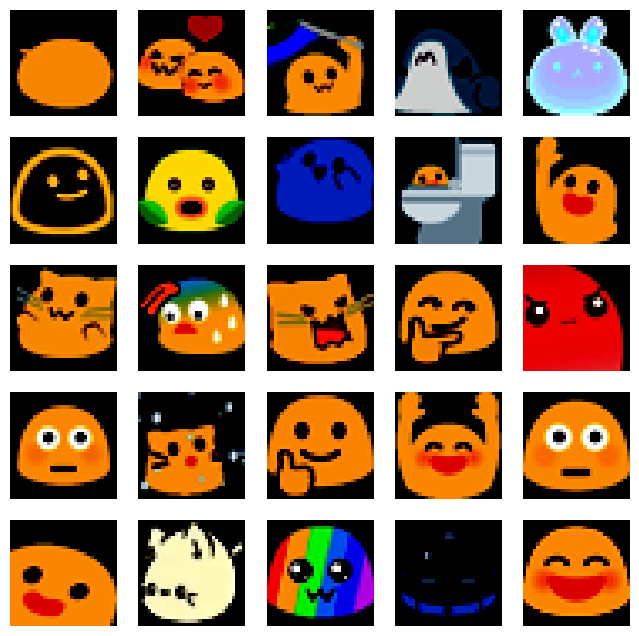

In [16]:
import os
WIDTH, HEIGHT = 32, 32
batch_size = 32


class EmojiDataset(Dataset):
    def __init__(self, csv_files, image_folder, transform=None):
        self.dataframe = pd.concat([pd.read_csv(csv_file)
                                   for csv_file in csv_files])
        self.images_folder = image_folder
        self.dataframe['image_path'] = self.dataframe['file_name'].str.replace(
            '\\', '/')
        self.image_paths = self.dataframe['image_path'].tolist()
        self.titles = self.dataframe['prompt'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.images_folder + '/' + self.image_paths[idx]
        title = self.titles[idx]
        title = title.replace('"', '').replace("'", '')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, title


transform = transforms.Compose([
    transforms.Resize(
        (WIDTH, HEIGHT),
        interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Verify CSV file existence
csv_path = "data/blobs_crawled_data/metadata.csv"
image_folder_path = "data/blobs_crawled_data/images"

if os.path.exists(csv_path):
    csv_files = [csv_path]
else:
    raise FileNotFoundError(
        f"Error: CSV file '{csv_path}' not found. Please check the file path.")

# Verify image folder existence
if os.path.exists(image_folder_path):
    image_folder = image_folder_path
else:
    raise FileNotFoundError(
        f"Error: Image folder '{image_folder_path}' not found. Please check the directory.")

print(f"CSV files located at: {csv_files}")
print(f"Image folder located at: {image_folder}")


train_dataset = EmojiDataset(
    csv_files=csv_files,
    image_folder=image_folder,
    transform=transform
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

dataiter = iter(train_dataloader)
images, titles = next(dataiter)

print(f"Batch images shape: {images.shape}")

clipped_images = torch.clamp(images, 0, 1)
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(clipped_images[i].permute(1, 2, 0).numpy())
    print(titles[i])
    plt.axis('off')
plt.show()

In [17]:
# Model training
def train(diffusion, vae, text_encoder, scheduler,
          optimizer, lr_scheduler, scaler,
          criterion, dataloader, num_epochs, device="cuda"):
    losses = []
    for epoch in range(num_epochs):
        diffusion.train()

        epoch_loss = 0.0
        progress_bar = tqdm(
            dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch_idx, (images, titles) in enumerate(progress_bar):
            images = images.to(device)
            image_titles = [f"A photo of {title}" for title in titles]
            # 50% image_titles là chuỗi rỗng
            image_titles = [title if random.random(
            ) < 0.5 else "" for title in image_titles]

            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample() * 0.18215

            timesteps = torch.randint(
                0, scheduler.total_train_timesteps,
                (latents.shape[0],), device=device
            )

            noisy_latents, noise = scheduler.add_noise(latents, timesteps)
            time_embeddings = embed_timesteps(timesteps).to(device)
            text_embeddings = text_encoder(image_titles)

            noise_pred = diffusion(
                noisy_latents, text_embeddings, time_embeddings)

            with autocast(device_type='cuda', dtype=torch.float16,
                          enabled=True, cache_enabled=True):
                loss = criterion(noise_pred, noise)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            epoch_loss += batch_loss

            progress_bar.set_postfix(loss=f"{batch_loss:.5f}",
                                     lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        lr_scheduler.step()
        avg_epoch_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_epoch_loss:.5f}")
        losses.append(avg_epoch_loss)

    print("Training finished!")
    return losses

In [18]:
# Train
EPOCHS = 5

h_dim = 384
n_head = 8

vae = vae.to(device)
diffusion = Diffusion(h_dim, n_head).to(device)
clip = CLIPTextEncoder().to(device)

random_generator = torch.Generator(device='cpu')
noise_scheduler = DDPMScheduler(random_generator)

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

lrate_scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS, eta_min=1e-5
)
scaler = GradScaler()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


vae_params = count_parameters(vae)
diffusion_params = count_parameters(diffusion)
clip_params = count_parameters(clip)

print(f"VAE parameters: {vae_params}")
print(f"Diffusion parameters: {diffusion_params}")
print(f"CLIP parameters: {clip_params}")
print(f"Total parameters: {vae_params + diffusion_params + clip_params}")

VAE parameters: 83653863
Diffusion parameters: 631718020
CLIP parameters: 63165952
Total parameters: 778537835


/home/quoc/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
plt.figure(figsize=(16, 8))

plt.plot(losses, label='Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

min_loss = min(losses)
min_loss_epoch = losses.index(min_loss)
plt.scatter(min_loss_epoch, min_loss, color='green', zorder=5)
plt.text(min_loss_epoch,
         min_loss+0.025,
         f'{min_loss:.4f}',
         fontsize=12,
         verticalalignment='center',
         horizontalalignment='center',
         color='green')

plt.legend()
plt.grid()
plt.savefig('training_loss.png')
plt.show()